In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim



In [2]:
class RdmDataset(Dataset):
    def __init__(self, root_dir, event_csv, actuator_csv, included_folders, window_size=100):
        self.data = []
        self.labels = []  # This will store labels for each window
        self.window_size = window_size
        
        # Load event labels and actuator frames
        self.event_labels_df = pd.read_csv(event_csv)
        self.actuator_df = pd.read_csv(actuator_csv)
        
        # Iterate only over included folders
        for folder_name in included_folders:
            folder_path = os.path.join(root_dir, folder_name)
            for file in sorted(os.listdir(folder_path)):
                if file.endswith('.npy'):
                    filepath = os.path.join(folder_path, file)
                    radar_capture = "_".join(file.split('_')[:-1])  # Extract radar capture name
                    
                    # Ensure radar_capture matches one of the entries in the actuator CSV
                    if self.actuator_df['RADAR_capture'].str.contains(radar_capture).any():
                        rdm_data = np.load(filepath)
                        rdm_data = torch.from_numpy(rdm_data).float()  # Convert numpy array to PyTorch tensor of type float


                        # Find corresponding actuator frames for this radar_capture
                        actuator_info = self.actuator_df[self.actuator_df['RADAR_capture'] == radar_capture].iloc[0]
                        # Adjust the start frame as per the requirement
                        actuator_start_frame, actuator_end_frame = actuator_info['RADAR_Start_Frame'] + 150, actuator_info['RADAR_End_Frame']
                        
                        # Create windows and label them
                        self.create_and_label_windows(rdm_data, radar_capture, actuator_start_frame, actuator_end_frame)
    
    def create_and_label_windows(self, rdm_data, radar_capture, actuator_start_frame, actuator_end_frame):
        num_frames = actuator_end_frame - actuator_start_frame + 1
        capture_labels = self.label_frames(radar_capture)  # Labels for entire capture
        
        for start in range(0, num_frames - self.window_size + 1, self.window_size // 2):
            actual_start = start + actuator_start_frame
            actual_end = actual_start + self.window_size
            
            if actual_end > actuator_end_frame:
                break  # Ensure we don't exceed the actuator_end_frame
                
            window_labels = capture_labels[actual_start:actual_end]  # Extract labels for the window
            self.data.append(rdm_data[actual_start:actual_end])
            self.labels.append(window_labels)

    def label_frames(self, radar_capture):
        num_frames = 1000  # Assuming a fixed size, adjust as necessary
        labels = np.full(num_frames, 2)  # Default to 3 (neither)
        capture_events = self.event_labels_df[self.event_labels_df['RADAR_capture'] == radar_capture]
        
        for _, event in capture_events.iterrows():
            if not pd.isna(event['Start_Frame']) and not pd.isna(event['frame_stable']):
                labels[int(event['Start_Frame']):int(event['frame_stable'])] = 0  # GOUP
            if not pd.isna(event['frame_break']) and not pd.isna(event['End_Frame']):
                labels[int(event['frame_break']):int(event['End_Frame'])] = 1  # DOWN
 
        return labels


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Assuming self.data is your dataset and self.labels are your labels
        data = self.data[index]
        label = self.labels[index]
        length = len(data)  # Or however you calculate the length of your sequence
        return data, label, length


def collate_fn(batch):
    # Separate the sequences and labels
    sequences, labels, _ = zip(*batch)
    
    # Remove the extra leading dimension and calculate lengths for each sequence in the batch
    sequences = [torch.tensor(seq, dtype=torch.float) for seq in sequences]  # Ensure sequences are tensors
    lengths = [len(seq) for seq in sequences]
    
    # Pad sequences to have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True)
    
    # Ensure labels are tensors
    labels = [torch.tensor(label, dtype=torch.long) for label in labels]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)  # Assuming -1 is an ignore_index
    
    lengths = torch.tensor(lengths, dtype=torch.long)

    return sequences_padded, labels_padded, lengths


In [36]:

# Define the model
class RdmClassifier(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(RdmClassifier, self).__init__()
        self.num_classes = num_classes  # Add this line
        # Define a simple CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Assuming RDMs have a single channel
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),  # This will flatten the output of the convolutional layers
        )
        cnn_output_size = self._get_conv_output_size()

        # Define the LSTM layer
        self.lstm = nn.LSTM(cnn_output_size, hidden_size, batch_first=True)
        
        

        
        # Define the fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        x = x.float()  # Ensure input is float type
        batch_size, seq_len, _, _ = x.size()
        # Apply CNN to each RDM in the sequence
        c_out = self.cnn(x.view(batch_size * seq_len, 1, *x.size()[-2:]))
        
        # Reshape for LSTM input
        r_out = c_out.view(batch_size, seq_len, -1)
        
        # Pack the sequence for LSTM
        packed_input = pack_padded_sequence(r_out, lengths, batch_first=True, enforce_sorted=False)
        # Instead of using just the last hidden state
        packed_output, (hidden, cell) = self.lstm(packed_input)
        # Decode the packed output
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # Apply the fully connected layer to all time steps
        out = self.fc(lstm_out)
        return out
    
    def _get_conv_output_size(self):
        # We can create a dummy input to calculate the output size after the CNN layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 23, 13)  # Replace with your RDM shape
            dummy_output = self.cnn(dummy_input)
            return dummy_output.size(-1)



In [4]:
actuator_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/FP_RADAR_FULL_DATA2.csv"
df = pd.read_csv(actuator_csv)
print(df.head())


    RADAR_capture                     Lift_Times            Down_Times  \
0  01_MNTRL_RR_V1       [12.60667, 18.25, 26.24]     [18.26083, 22.83]   
1  01_MNTRL_RR_V2          [10.48, 18.41, 26.46]        [15.05, 22.86]   
2  01_MNTRL_RR_V3        [10.66, 18.2525, 26.35]        [15.16, 22.83]   
3  01_MNTRR_RR_V1    [10.07, 18.33167, 26.07333]  [14.99333, 23.01917]   
4  01_MNTRR_RR_V2  [10.6825, 18.65167, 26.65667]  [15.18417, 23.34917]   

   MOCAP_End_Time  Seconds_per_Frame  MOCAP_Start_Time  RADAR_Start_Frame  \
0           30.57           0.036454              1.86                 44   
1           30.40           0.036464              1.90                 41   
2           31.88           0.036547              1.92                 43   
3           30.23           0.036467              1.91                 45   
4           30.66           0.036370              1.95                 41   

   RADAR_End_Frame  
0              831  
1              822  
2              862  
3       

In [5]:
capture_frame_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES.csv"

root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_1Ch'


all_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
num_train_folders = int(len(all_folders) * 0.8)
train_folders = all_folders[:num_train_folders]
test_folders = all_folders[num_train_folders:]

train_dataset = RdmDataset(root_dir=root_dir, event_csv=capture_frame_csv_path, actuator_csv=actuator_csv, included_folders=train_folders, window_size=100)
test_dataset = RdmDataset(root_dir=root_dir, event_csv=capture_frame_csv_path, actuator_csv=actuator_csv, included_folders=test_folders, window_size=100)

# Adjust 'root_dir' and 'csv_file' to point to your test dataset
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [26]:
all_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Assuming all folders are named or ordered in such a way that participant data is together
# and that the sorting provides a meaningful order

num_train_folders = int(len(all_folders) * 0.7)
num_val_folders = int(len(all_folders) * 0.15)

# Remaining folders will be for testing

train_folders = all_folders[:num_train_folders]
val_folders = all_folders[num_train_folders:num_train_folders + num_val_folders]
test_folders = all_folders[num_train_folders + num_val_folders:]

train_dataset = RdmDataset(root_dir=root_dir, event_csv=capture_frame_csv_path, actuator_csv=actuator_csv, included_folders=train_folders, window_size=100)
val_dataset = RdmDataset(root_dir=root_dir, event_csv=capture_frame_csv_path, actuator_csv=actuator_csv, included_folders=val_folders, window_size=100)
test_dataset = RdmDataset(root_dir=root_dir, event_csv=capture_frame_csv_path, actuator_csv=actuator_csv, included_folders=test_folders, window_size=100)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)


In [28]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of val samples: {len(val_dataset)}")

data, labels, lengths = next(iter(train_loader))
print(data.shape, labels.shape, lengths)


Number of training samples: 2556
Number of testing samples: 784
Number of val samples: 512
torch.Size([2, 100, 23, 13]) torch.Size([2, 100]) tensor([100, 100])


(100, 23, 13)
Label: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


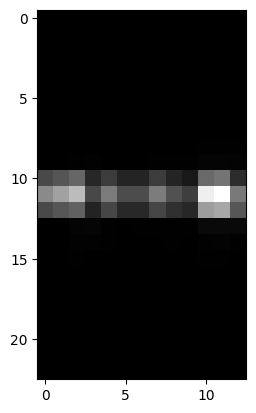

(100, 23, 13)
Label: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


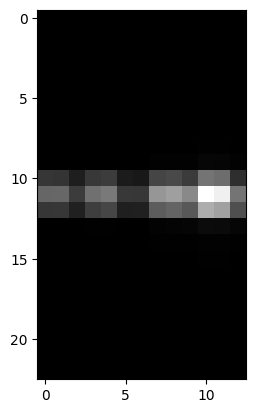

(100, 23, 13)
Label: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


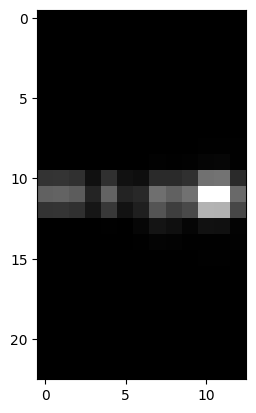

In [7]:
import matplotlib.pyplot as plt

def visualize_sample(data, label):
    print(data.shape)
    # Assuming your data is a 2D RADAR sequence, adjust accordingly
    # This is a simple visualization, consider plotting individual frames
    print(f"Label: {label}")
    plt.imshow(data[0], cmap='gray')  # Just visualize the first frame for simplicity
    plt.show()

# Visualize a few samples from the test set
for i in range(3):
    data, label, _ = test_dataset[i]
    visualize_sample(np.array(data), label)  # Convert to numpy if it's a tensor


In [37]:
# Initialize the model
num_classes = 3  # GOUP, BLNC, DOWN
hidden_size = 128
model = RdmClassifier(num_classes=num_classes, hidden_size=hidden_size)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):
        total_loss = 0
        for data, labels, lengths in train_loader:  # Adjust to unpack lengths
            optimizer.zero_grad()
            data = data.float()  # Ensure data is in float
            outputs = model(data, lengths)  # Pass both data and lengths to the model
            outputs_flat = outputs.view(-1, num_classes)  # Flatten output for loss calculation
            labels_flat = labels.view(-1)  # Flatten labels
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs=7)

In [30]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0  # Keep track of total predictions for accuracy calculation

    with torch.no_grad():  # Disable gradient computation
        for data, labels, lengths in test_loader:  # Adjust to unpack lengths
            data = data.float()  # Ensure data is in float
            outputs = model(data, lengths)  # Pass both data and lengths to the model
            outputs_flat = outputs.view(-1, num_classes)  # Flatten output for loss calculation
            labels_flat = labels.view(-1)  # Flatten labels for consistency with loss calculation

            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

            # Calculate predictions
            _, predicted = torch.max(outputs_flat.data, 1)

            # Update correct predictions count
            correct_predictions += (predicted == labels_flat).sum().item()
            total_predictions += labels_flat.size(0)  # Update total predictions

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions  # Calculate accuracy using total predictions
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


In [35]:
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0
        for data, labels, lengths in train_loader:
            optimizer.zero_grad()
            data = data.float()  # Ensure data is float
            outputs = model(data, lengths)
            outputs_flat = outputs.view(-1, model.num_classes)
            labels_flat = labels.view(-1)
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, labels, lengths in val_loader:
                data = data.float()
                outputs = model(data, lengths)
                outputs_flat = outputs.view(-1, model.num_classes)
                labels_flat = labels.view(-1)
                loss = criterion(outputs_flat, labels_flat)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


In [38]:
# Assuming train_loader and test_loader are already defined
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch [1/7], Training Loss: 0.4807, Validation Loss: 0.3151
Epoch [2/7], Training Loss: 0.2715, Validation Loss: 0.1490
Epoch [3/7], Training Loss: 0.2405, Validation Loss: 0.1308
Epoch [4/7], Training Loss: 0.2084, Validation Loss: 0.3528
Epoch [5/7], Training Loss: 0.2320, Validation Loss: 0.1339
Epoch [6/7], Training Loss: 0.1876, Validation Loss: 0.1362
Epoch [7/7], Training Loss: 0.1849, Validation Loss: 0.1253


In [39]:
# Saving the entire model (architecture + weights)
torch.save(model, '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/full_model_v2_val.pth')

# Saving only the state dictionary (recommended)
torch.save(model.state_dict(), '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/model_state_dict_v2_val.pth')


In [22]:
# Assuming the RdmClassifier class is already defined
# Instantiate the model
loaded_model = RdmClassifier(num_classes=num_classes, hidden_size=hidden_size)

# Load the saved state dict
loaded_model.load_state_dict(torch.load('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/model_state_dict_v1.pth'))

# Make sure to call .eval() if you're doing inference to set dropout and batch normalization layers to evaluation mode
loaded_model.eval()


RdmClassifier(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): LSTM(1056, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [23]:
test_model(loaded_model, test_loader, criterion)

Test Loss: 0.2286, Accuracy: 0.9242


In [40]:
test_model(model, test_loader, criterion)

Test Loss: 0.2358, Accuracy: 0.9273


torch.Size([1, 100, 23, 13]) torch.Size([100])


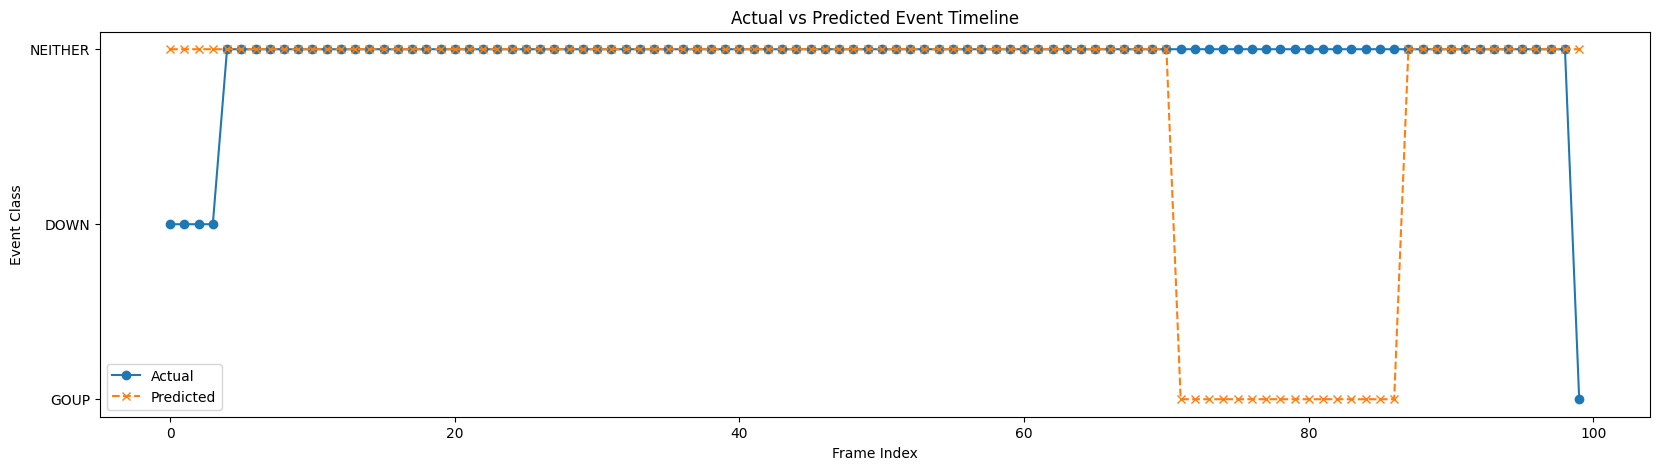

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_timeline(sample_data, model, actual_labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Assuming sample_data is already in the correct shape: [1, seq_len, height, width]
        # and actual_labels is a tensor of shape [seq_len]
        lengths = torch.tensor([len(sample_data[0])])  # [seq_len]
        predictions = model(sample_data, lengths)  # Get predictions from the model
        predicted_labels = torch.argmax(predictions.squeeze(), dim=1)  # Convert predictions to label indices
        
    # Convert tensors to numpy arrays for plotting
    actual_labels = actual_labels.numpy()
    predicted_labels = predicted_labels.numpy()
    
    # Generate x values (frame indices)
    x_values = np.arange(len(actual_labels))
    
    plt.figure(figsize=(20, 5))
    
    # Plot actual labels
    plt.plot(x_values, actual_labels, label='Actual', marker='o')
    
    # Plot predicted labels
    plt.plot(x_values, predicted_labels, label='Predicted', linestyle='--', marker='x')
    
    plt.yticks([0, 1, 2], ['GOUP', 'DOWN', 'NEITHER'])
    plt.xlabel('Frame Index')
    plt.ylabel('Event Class')
    plt.title('Actual vs Predicted Event Timeline')
    plt.legend()
    plt.show()

# Example usage:
# Assuming 'sample_data' is your input radar sequence tensor, and 'actual_labels' is the tensor of actual labels
# sample_data should be shaped [1, seq_len, height, width], and actual_labels should be shaped [seq_len]
# Assuming 'train_loader' is your DataLoader instance
# Assuming 'train_loader' is your DataLoader instance
batch_data, batch_labels, batch_lengths = next(iter(test_loader))

# To get a single sample from this batch, you can simply index into these tensors
sample_data = batch_data[0].unsqueeze(0)  # Adds an extra dimension to make it [1, seq_len, height, width]
sample_labels = batch_labels[0]  # The labels corresponding to the first sample
sample_length = batch_lengths[0]  # The length of the first sample

print(sample_data.shape, sample_labels.shape)

# Now, sample_data, sample_labels, and sample_lengths contain the first batch of your dataset

visualize_timeline(sample_data, model, sample_labels)


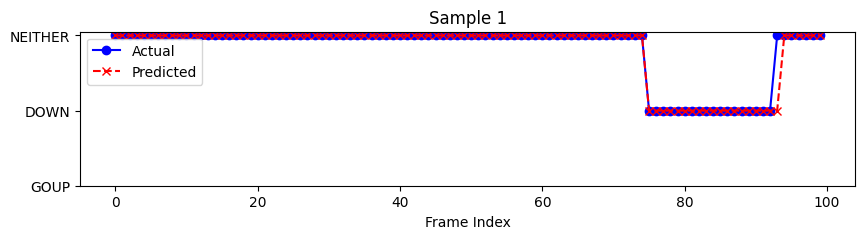

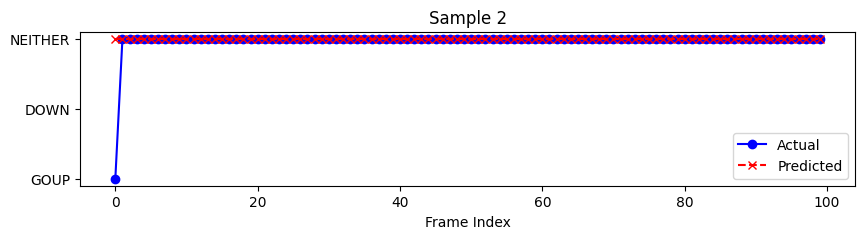

In [42]:
import matplotlib.pyplot as plt
import torch

def visualize_timeline(sample_data, model, actual_labels, lengths):
    model.eval()
    with torch.no_grad():
        # Assuming your model outputs logits that need softmax
        predictions = model(sample_data, lengths)
        predictions = torch.softmax(predictions, dim=-1)
        predicted_labels = torch.argmax(predictions, dim=-1)

    # Visualizing timelines for the first few samples in the batch
    num_samples_to_visualize = 5  # Adjust based on how many samples you want to visualize
    for i in range(min(num_samples_to_visualize, sample_data.size(0))):
        plt.figure(figsize=(10, 2))
        x_values = list(range(lengths[i].item()))
        actual = actual_labels[i][:lengths[i]].cpu().numpy()
        predicted = predicted_labels[i][:lengths[i]].cpu().numpy()
        
        plt.plot(x_values, actual, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(x_values, predicted, label='Predicted', linestyle='--', marker='x', color='red')
        
        plt.yticks([0, 1, 2], ['GOUP', 'DOWN', 'NEITHER'])
        plt.xlabel('Frame Index')
        plt.title(f'Sample {i+1}')
        plt.legend()
        plt.show()

# Fetch a batch from the test data loader
batch_data, batch_labels, batch_lengths = next(iter(test_loader))

# Visualize the timeline for samples in the batch
visualize_timeline(batch_data, model, batch_labels, batch_lengths)


In [15]:
torch.save(model.state_dict(), "model.pt")

ModuleNotFoundError: No module named 'torch_model_archiver'

OSError: No such file: model.mar